# Importing Libraries

In [ ]:
%%capture
!pip install ecg_plot
!pip install wfdb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
sns.set()
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Choosing the device you want : cpu , gpu or tpu

device_type = input("Please choose the type of device you want to use : ")
if device_type=="cpu":
    device = torch.device("cpu")
elif device_type=="gpu":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif device_type=="tpu":
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()

print("\nYou are using ", device)

Please choose the type of device you want to use : gpu

You are using  cuda:0


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = '16_yuqeOZbvoW-TbFMScvR_h2CDLBmGHg'
downloaded2 = drive.CreateFile({'id': file_id})

# Data Loading

In [ ]:
file_id = '1PoYFw_ALRLiLhVxR1ddB0Fho3KAMEgCM'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
downloaded.GetContentFile('mitbih.zip')

In [ ]:
%%capture
!unzip mitbih.zip

## Random Test and Initial Visualization

Let us consider the Recording 100

In [ ]:
signals,fields = wfdb.rdsamp("/content/mit-bih-arrhythmia-database-1.0.0/100")

In [ ]:
print(fields)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


In [ ]:
signal_v5 = signals[:,1].reshape(-1)

In [ ]:
attr_check = wfdb.rdann('/content/mit-bih-arrhythmia-database-1.0.0/100',extension='atr')

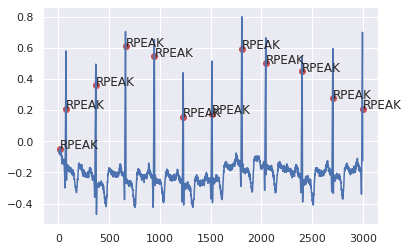

In [ ]:
plt.plot(signal_v5[:3000])
for i in attr_check.sample[attr_check.sample<3000]:
    plt.scatter(i,signal_v5[i],marker='o',c='r')
    plt.annotate("RPEAK",(i,signal_v5[i]))
plt.show()

# Data Preprocessing

In [ ]:
records = np.loadtxt('/content/mit-bih-arrhythmia-database-1.0.0/RECORDS',delimiter='\n').astype(int)

In [ ]:
print(records)

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


Out of the 22 different type of beats, we consider only 10 classes which are considered in this work.

In [ ]:
beat_classes = ['A','L','N','/','R','V','f','F','!','j']
beat_transform = {'A':0,'L':1,'N':2,'/':3,'R':4,'V':5,'f':6,'F':7,'!':8,'j':9}
beat_inv_transform = {v:k for k,v in beat_transform.items()}

##Analysis



> **Unique Leads**



There are two leads present for every record, but it is observed that the two leads are not the same for every record, so let us check what unique leads are there for getting an idea.



> **Unique Symbols**

There are various classes into which the beats have been annotated, to get an idea regarding what are the various classes, let us do a search.



> **Beat-Record Distribution**


*   Classes of beats and they occur in which records
*   Number and type of beats in each record





In [ ]:
unique_leads = []
unique_symbols = []
beat_record = {}
record_analyse = {}

for bt in beat_classes:
    beat_record[bt] = []


for record in records:

    record_analyse[record] = {}
    test_signal,test_field = wfdb.rdsamp('/content/mit-bih-arrhythmia-database-1.0.0/'+str(record))
    unique_leads += test_field['sig_name']
    test_attr = wfdb.rdann('/content/mit-bih-arrhythmia-database-1.0.0/'+str(record),extension='atr')
    symbols = test_attr.symbol
    unique_symbols += symbols

    for bt in beat_classes:
        if bt in set(symbols):
            beat_record[bt].append(record)

    for bt in beat_classes:
        symbols = np.array(symbols)
        record_analyse[record][bt] = symbols[symbols==bt].shape[0]

print("\n\n--> The Unique leads of the ECG used are : ",list(set(unique_leads)))
print("\n\n--> There are ",len(list(set(unique_symbols)))," Unique Annotaion Symbol of the ECG used which are as follows :\n",list(set(unique_symbols)))
print("\n\n--> The symbol-record distribution is :\n")
print("Beat Class\t","\tRecord Names")
for k, v in beat_record.items():
    print(k,"\t\t\t",v)

print("\n\n--> The various beats (of interest) in each record is : ")
df = pd.DataFrame.from_dict(record_analyse).transpose()

df['Sum'] = df.sum(axis=1)
df.loc['Total'] = df.sum()
display(df)



--> The Unique leads of the ECG used are :  ['MLII', 'V4', 'V2', 'V5', 'V1']


--> There are  23  Unique Annotaion Symbol of the ECG used which are as follows :
 ['A', '/', '!', '"', 'F', 'f', '[', 'R', 'N', 'S', '+', 'Q', 'e', 'J', '|', 'j', ']', 'a', 'x', '~', 'L', 'V', 'E']


--> The symbol-record distribution is :

Beat Class	 	Record Names
A 			 [100, 101, 103, 108, 112, 114, 116, 117, 118, 121, 124, 200, 201, 202, 205, 207, 209, 213, 215, 219, 220, 222, 223, 228, 231, 232, 233]
L 			 [109, 111, 207, 214]
N 			 [100, 101, 102, 103, 104, 105, 106, 108, 112, 113, 114, 115, 116, 117, 119, 121, 122, 123, 200, 201, 202, 203, 205, 208, 209, 210, 212, 213, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 233, 234]
/ 			 [102, 104, 107, 217]
R 			 [118, 124, 207, 212, 231, 232]
V 			 [100, 102, 104, 105, 106, 107, 108, 109, 111, 114, 116, 118, 119, 121, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 213, 214, 215, 217, 219, 221, 223, 228, 230, 231, 233, 234]
f 			 [102, 104, 21

,A,L,N,/,R,V,f,F,!,j,Sum
100,33,0,2239,0,0,1,0,0,0,0,2273
101,3,0,1860,0,0,0,0,0,0,0,1863
102,0,0,99,2028,0,4,56,0,0,0,2187
103,2,0,2082,0,0,0,0,0,0,0,2084
104,0,0,163,1380,0,2,666,0,0,0,2211
105,0,0,2526,0,0,41,0,0,0,0,2567
106,0,0,1507,0,0,520,0,0,0,0,2027
107,0,0,0,2078,0,59,0,0,0,0,2137
108,4,0,1739,0,0,17,0,2,0,1,1763
109,0,2492,0,0,0,38,0,2,0,0,2532


## Initial Data Ingestion

In [ ]:
ecg_signals = {}
ecg_labels = {}

In [ ]:
for record in records :
    
    temp_signals,temp_fields = wfdb.rdsamp('/content/mit-bih-arrhythmia-database-1.0.0/'+str(record))
    test_attr = wfdb.rdann('/content/mit-bih-arrhythmia-database-1.0.0/'+str(record),extension='atr')
    ecg_labels[record] = {}
    ecg_labels[record]['sample'] = test_attr.sample
    ecg_labels[record]['symbol'] = test_attr.symbol
    ecg_labels[record]['full'] = [ (symbol,sample) for symbol,sample in zip(test_attr.symbol,test_attr.sample) ] 
    ecg_signals[record] = {}
    ecg_signals[record]['leads'] = temp_fields['sig_name']

    for n,i in enumerate(ecg_signals[record]['leads']):

        ecg_signals[record][i] = temp_signals[:,n].reshape(-1)

# ECG Beat Segmentation

## Main

In [ ]:
fs = 360 # Sampling Rate
bp = 0.35
ap = 0.45

In [ ]:
beat_matrix = []

In [ ]:
for record in records:

    for lead in ecg_signals[record]['leads']:

        length = ecg_signals[record][lead].shape[0]

        for sym,samp in ecg_labels[record]['full']:

            if (((samp-bp*fs)>0) and ((samp+ap*fs)<length) and (sym in beat_classes)):

                beat_matrix.append([ecg_signals[record][lead][int(samp-bp*fs):int(samp+ap*fs)],beat_transform[sym]])

In [ ]:
print(len(beat_matrix))

219054


## Visualization

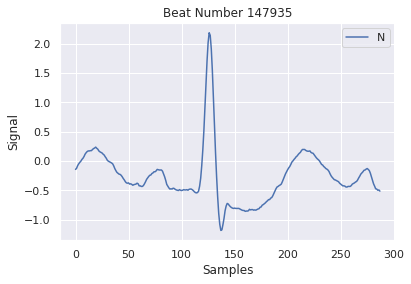

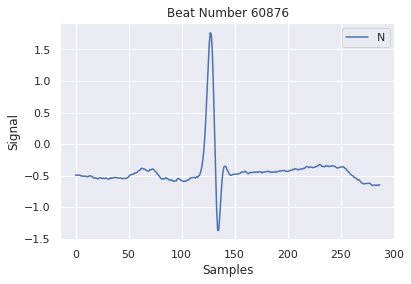

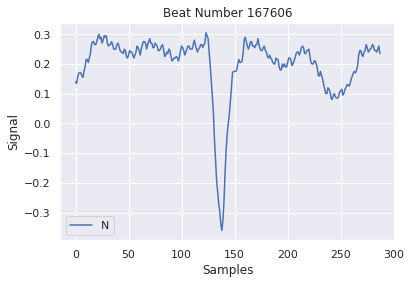

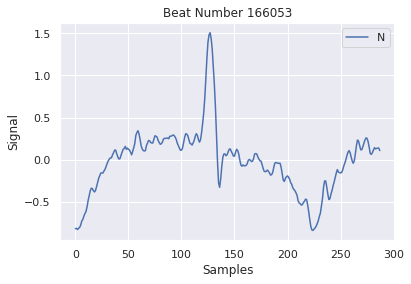

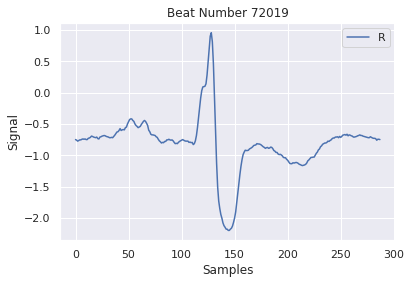

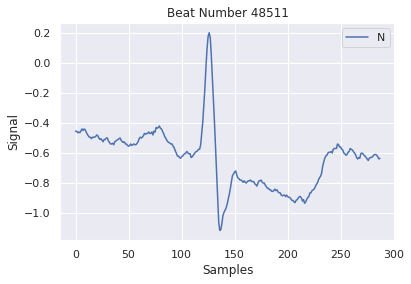

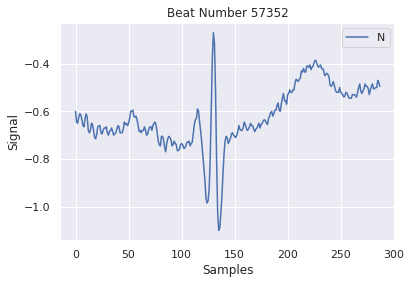

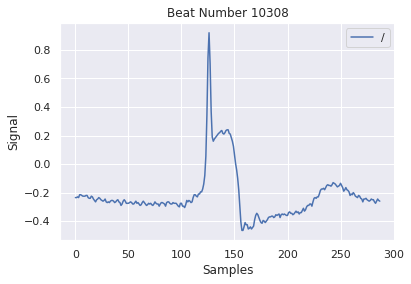

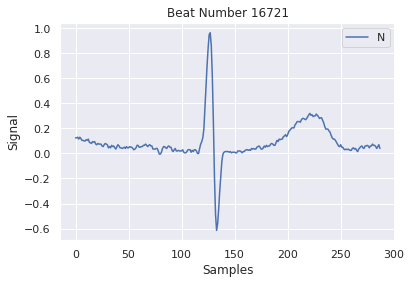

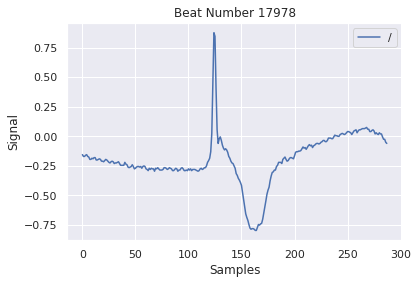

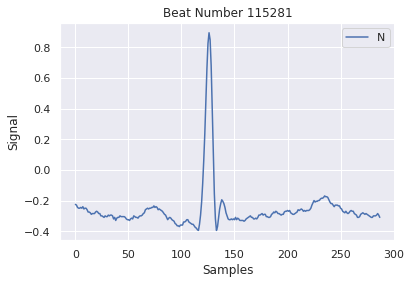

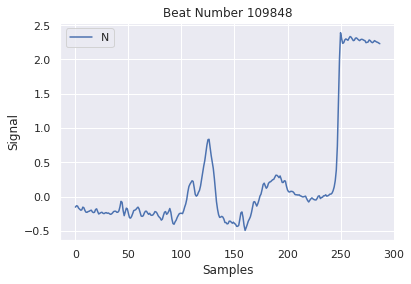

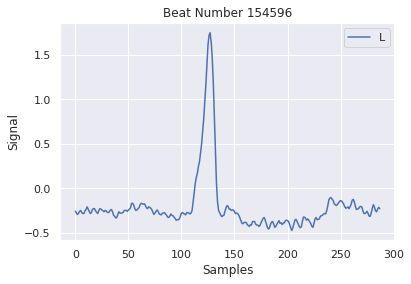

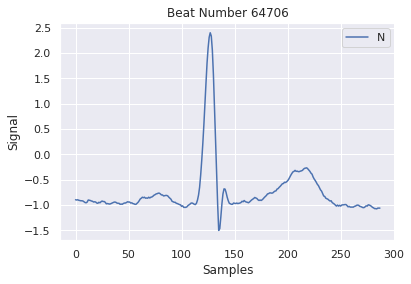

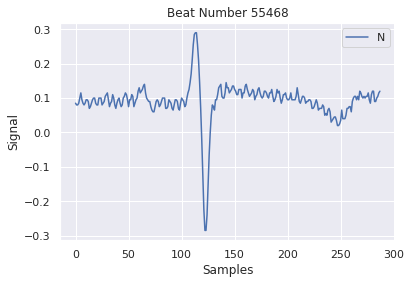

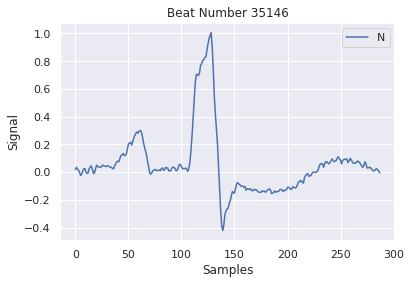

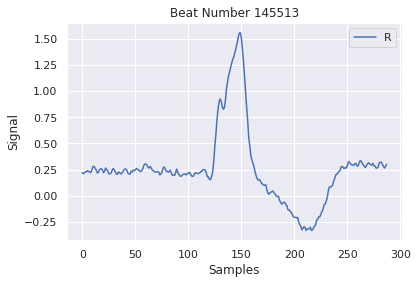

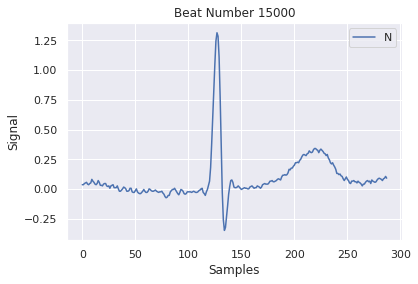

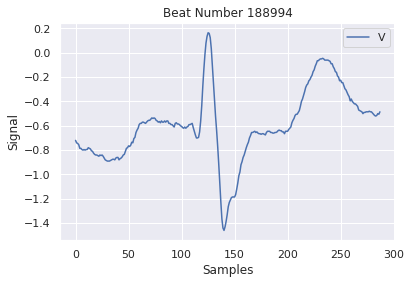

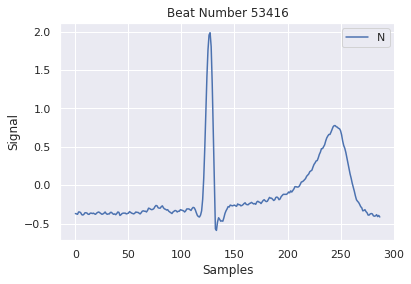

In [ ]:
for i in np.random.randint(0,len(beat_matrix),20):
    plt.plot(beat_matrix[i][0],label=beat_inv_transform[beat_matrix[i][1]])
    plt.xlabel("Samples")
    plt.ylabel("Signal")
    plt.title("Beat Number "+str(i))
    plt.legend()
    plt.show()

In [ ]:
beat_matrix = np.array(beat_matrix)

# Data Preparation

## Train-Validation-Test Split

In [ ]:
X_train, X_test_, y_train, y_test_ = train_test_split(beat_matrix[:,0],beat_matrix[:,1],test_size=0.2,shuffle=True,stratify=beat_matrix[:,1],random_state=1)
X_test,X_val,y_test,y_val = train_test_split(X_test_,y_test_,test_size=0.5,shuffle=True,stratify=y_test_,random_state=1)

In [ ]:
X_train = np.array(list(X_train))
y_train = np.array(list(y_train))
X_val = np.array(list(X_val))
y_val = np.array(list(y_val))
X_test = np.array(list(X_test))
y_test = np.array(list(y_test))

In [ ]:
print(" The shape of X_train is ",X_train.shape)
print(" The shape of y_train is ",y_train.shape)
print(" The shape of X_val is ",X_val.shape)
print(" The shape of y_val is ",y_val.shape)
print(" The shape of X_test is ",X_test.shape)
print(" The shape of y_test is ",y_test.shape)

 The shape of X_train is  (175243, 288)
 The shape of y_train is  (175243,)
 The shape of X_val is  (21906, 288)
 The shape of y_val is  (21906,)
 The shape of X_test is  (21905, 288)
 The shape of y_test is  (21905,)


## Batching

### Training

In [ ]:
batch_size = 31
n_batches = X_train.shape[0]/batch_size

In [ ]:
train_dict = {}
train_dict['batches'] = {}
val_dict = {}
test_dict = {}

In [ ]:
train_dict['X_train'] = X_train
train_dict['y_train'] = y_train
val_dict['X_val'] = X_val
val_dict['y_val'] = y_val
test_dict['X_test'] = X_test
test_dict['y_test'] = y_test

In [ ]:
train_dict['batches']['X'] = np.split(X_train,n_batches)
train_dict['batches']['y'] = np.split(y_train,n_batches)

In [ ]:
train_dict['batches']['X'][0].shape

(31, 288)

### Validation

In [ ]:
batch_size_val = 1217
n_batches_val = X_val.shape[0]/batch_size_val

In [ ]:

val_dict['batches'] = {}

In [ ]:
val_dict['batches']['X'] = np.split(X_val,n_batches_val)
val_dict['batches']['y'] = np.split(y_val,n_batches_val)

In [ ]:
val_dict['batches']['X'][0].shape

(1217, 288)

### Test

In [ ]:
batch_size_test = 1685
n_batches_test = X_test.shape[0]/batch_size_test

In [ ]:

test_dict['batches'] = {}

In [ ]:
test_dict['batches']['X'] = np.split(X_test,n_batches_test)
test_dict['batches']['y'] = np.split(y_test,n_batches_test)

In [ ]:
test_dict['batches']['X'][0].shape

(1685, 288)

# HeartNet Model for Beat Classification

In [ ]:
class HeartNetEC(nn.Module):

    def __init__(self,length):


        super().__init__()
        self.length = length

        self.descend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=1,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,1,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (1,4,L) --> (1,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.descend_Stage1_i_Stage2 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,4,L) --> (N,4,L/2)

        self.descend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=4,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,4,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.descend_Stage2_i_Stage3 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,8,L/2) --> (N,8,L/4)

        self.descend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=8,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,8,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),#(N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.descend_Stage3_i_Stage4 = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,16,L/4) --> (N,16,L/8)

        self.descend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=16,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,16,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.descend_Stage4_i_floor = nn.MaxPool1d(kernel_size=2,stride=2)   # (N,32,L/8) --> (N,32,L/16)

        self.floor = nn.Sequential(

            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,32,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=9,stride=1,padding=4), # (N,64,L/16) --> (N,64,L/16)
            nn.BatchNorm1d(64),# (N,64,L/16) --> (N,64,L/16)
            nn.ReLU()
        )

        self.ascend_floor_i_Stage4 = nn.ConvTranspose1d(in_channels=64,out_channels=64,kernel_size=8,stride=2,padding=3) # (N,64,L/16) --> (N,64,L/8)

        self.ascend_Stage4 = nn.Sequential(

            nn.Conv1d(in_channels=96,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,96,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),# (N,32,L/8) --> (N,32,L/8)
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=9,stride=1,padding=4), # (N,32,L/8) --> (N,32,L/8)
            nn.BatchNorm1d(32),#(N,32,L/8) --> (N,32,L/8)
            nn.ReLU()
        )

        self.ascend_Stage4_i_Stage3 = nn.ConvTranspose1d(in_channels=32,out_channels=32,kernel_size=8,stride=2,padding=3) # (N,32,L/8) --> (N,32,L/4)

        self.ascend_Stage3 = nn.Sequential(

            nn.Conv1d(in_channels=48,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,48,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=16,kernel_size=9,stride=1,padding=4), # (N,16,L/4) --> (N,16,L/4)
            nn.BatchNorm1d(16),# (N,16,L/4) --> (N,16,L/4)
            nn.ReLU()
        )

        self.ascend_Stage3_i_Stage2 = nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=8,stride=2,padding=3) # (N,16,L/4) --> (N,16,L/2)

        self.ascend_Stage2 = nn.Sequential(

            nn.Conv1d(in_channels=24,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,24,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels=8,kernel_size=9,stride=1,padding=4), # (N,8,L/2) --> (N,8,L/2)
            nn.BatchNorm1d(8),# (N,8,L/2) --> (N,8,L/2)
            nn.ReLU()
        )

        self.ascend_Stage2_i_Stage1 = nn.ConvTranspose1d(in_channels=8,out_channels=8,kernel_size=8,stride=2,padding=3) # (N,8,L/2) --> (N,8,L)

        self.ascend_Stage1 = nn.Sequential(

            nn.Conv1d(in_channels=12,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,12,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels=4,kernel_size=9,stride=1,padding=4), # (N,4,L) --> (N,4,L)
            nn.BatchNorm1d(4),# (N,4,L) --> (N,4,L)
            nn.ReLU()
        )

        self.fe_output = nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1)          # (N,4,L) --> (N,1,L)

        self.cl_stage_1 = nn.Sequential(
            
            nn.Linear(in_features=self.length,out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.final_stage = nn.Linear(in_features=64,out_features=10)


    def forward(self,x):

  

        # Pass through Descend Stage-1

        d_1 = self.descend_Stage1(x)



        # Move to Descend Stage-2

        d_1_i_2 = self.descend_Stage1_i_Stage2(d_1)

 

        # Pass through Descend Stage-2

        d_2 = self.descend_Stage2(d_1_i_2)

  

        # Move to Descend Stage-3

        d_2_i_3 = self.descend_Stage2_i_Stage3(d_2)



        # Pass through Descend Stage-3

        d_3 = self.descend_Stage3(d_2_i_3)



        # Move to Descend Stage-4


        d_3_i_4 = self.descend_Stage3_i_Stage4(d_3)



        # Pass through Descend Stage-4

        d_4 = self.descend_Stage4(d_3_i_4)



        # Move to Floor

        d_4_i_f = self.descend_Stage4_i_floor(d_4)



        # Pass through Floor

        d_f = self.floor(d_4_i_f)



        # Move to Ascend Stage-4

        a_f_i_4 = self.ascend_floor_i_Stage4(d_f)


        # Prepare for Ascend Stage-4



        a_p_4 = torch.cat((d_4,a_f_i_4),dim=1)


        # Pass through Ascend Stage-4


        a_4 = self.ascend_Stage4(a_p_4)


        # Move to Ascend Stage-3


        a_4_i_3 = self.ascend_Stage4_i_Stage3(a_4)


        # Prepare for Ascend Stage-3


        a_p_3 = torch.cat((d_3,a_4_i_3),dim=1)


        # Pass through Ascend Stage-3


        a_3 = self.ascend_Stage3(a_p_3)


        # Move to Ascend Stage-2

        a_3_i_2 = self.ascend_Stage3_i_Stage2(a_3)


        # Prepare for Ascend Stage-2

        a_p_2 = torch.cat((d_2,a_3_i_2),dim=1)


        # Pass through Stage-2

        a_2 = self.ascend_Stage2(a_p_2)


        # Move to Ascend Stage-1

        a_2_i_1 = self.ascend_Stage2_i_Stage1(a_2)



        # Prepare for Ascend Stage-1

        a_p_1 = torch.cat((d_1,a_2_i_1),dim=1)


        # Pass through Ascend Stage-1


        a_1 = self.ascend_Stage1(a_p_1)


        # Pass through Final Stage of Feature Extractor


        fe_output = self.fe_output(a_1)

        # Pass through FF Stage - 1

        cl_out_1 = self.cl_stage_1(fe_output.squeeze())

        # Pass through the Final Classifier Stage

        final_output = self.final_stage(cl_out_1)


        return final_output

In [ ]:
tst = HeartNetEC(288)
print(tst)

HeartNetEC(
  (descend_Stage1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage1_i_Stage2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage2): Sequential(
    (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (descend_Stage2_i_Stage3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (descend_Stage3): Sequ

# Evaluator

## Helper Functions

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.show()

In [ ]:
def evaluation(model,config,data,trueLabels,mode,name):

    """ Main Evaluator Function """

    predictedLabels = []

    for data_batch in data:

        data_batch = torch.FloatTensor(data_batch.reshape(config[name],1,-1)).to(device)

        with torch.no_grad():
            temp_predictions = model(data_batch)

    
        del data_batch
        torch.cuda.empty_cache()
        
        predictedLabels = np.append(predictedLabels,list(np.argmax(np.array(temp_predictions.cpu()),axis=1)))




    conf_mat = confusion_matrix(trueLabels,predictedLabels)

    num_TP = {}
    num_FP = {}
    num_FN = {}
    num_TN = {}

    num_TP['all'] = 0
    num_FP['all'] = 0
    num_FN['all'] = 0


    for beat_type in config['beat_classes']:

        num_TP[beat_type] = float(conf_mat[config['beat_transform'][beat_type],config['beat_transform'][beat_type]])
        num_FP[beat_type] = np.sum(conf_mat[:,config['beat_transform'][beat_type]]) - num_TP[beat_type]
        num_FN[beat_type] = np.sum(conf_mat[config['beat_transform'][beat_type],:]) - num_TP[beat_type]
        num_TN[beat_type] = np.sum(conf_mat) - num_TP[beat_type] - num_FP[beat_type] - num_FN[beat_type]

        num_TP['all'] += num_TP[beat_type]
        num_FP['all'] += num_FP[beat_type]
        num_FN['all'] += num_FN[beat_type]

    precision_full = (num_TP['all']/(num_TP['all']+num_FP['all']))
    sensitivity_full = (num_TP['all']/(num_TP['all']+num_FN['all']))
    f1_full = (2*precision_full*sensitivity_full)/(precision_full+sensitivity_full)
    accuracy_full = (num_TP['all'])/np.sum(conf_mat)

    if mode == "Validation":

        return {"accuracy":accuracy_full,
                "precision":precision_full,
                "sensitivity":sensitivity_full,
                "F1":f1_full
               }

    if mode == "Evaluation":

        metrics = classification_report(trueLabels,predictedLabels,target_names=config['beat_classes'],output_dict=True)

        for beat_type in config['beat_classes']:

            metrics[beat_type]["Accuracy"] = (num_TP[beat_type]+num_TN[beat_type])/np.sum(conf_mat)

        metrics['all'] = {}

        metrics['all']['precision'] = precision_full 
        metrics['all']['recall'] = sensitivity_full
        metrics['all']['f1-score'] = f1_full
        metrics['all']['Accuracy'] = accuracy_full

        return metrics,conf_mat

# Core Training Setup



> **Some Remarks on Training**


* Please note that here we consider 31 ECG beats are considered to be a single batch. 
* The model has to classify each and every beat so as to belong to one of the ten classes.
* We use **Cross Entropy Loss** as the loss function.
* The optimizer used is **Adam** optimizer.
* Also note that Checkpointing is used to save and evaluate the model with the least validation loss.


In [ ]:
config = {}

In [ ]:
config['batch_size'] = batch_size
config['n_batches'] = n_batches
config['batch_size_val'] = batch_size_val
config['n_batches_val'] = n_batches_val
config['batch_size_test'] = batch_size_test
config['n_batches_test'] = n_batches_test
config['feature_length'] = 288
config['lr'] = 0.001
config['device'] = device
config['device_type'] = device_type
config['beat_classes'] = beat_classes
config['beat_transform'] = beat_transform
config['beat_inv_transform'] = beat_inv_transform

## Core Training Function

In [ ]:
def ultimate_trainer(trainData,valData,testData,epochs,config,verbose=False,visualize=True,download_model=False):

    """ Trains HeartNet Models for Beat Classification """

    print("------------------------------------------------------------------------------------------")
    print("\t\t\t TRAINING EXPERIMENT")
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING CONFIGURATION")
    print("------------------------------------------------------------------------------------------")

    print("--> The HeartNet Model is being trained for Beat Classification")
    print("--> You are using a  " + config['device_type'])
    print("--> The epochs specified for training : ",epochs)
    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING")
    print("------------------------------------------------------------------------------------------")


    # Model Instantiation and Model Parameters

    model = HeartNetEC(config['feature_length'])

    model = model.to(config['device'])

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr=config['lr'])

    # Some variables for Training and Validation Visualization
    sensitivity_plot_val = []
    precision_plot_val = []
    F1_plot_val = []
    accuracy_plot_val = []

    loss_train_plot = []
    sensitivity_plot_train = []
    precision_plot_train = []
    F1_plot_train = []
    accuracy_plot_train = []

    # Some variables for Checkpointing

    min_train_loss = 1000
    max_val_F1 = 0
    max_train_F1 = 0

    # Training

    for epoch in tqdm_notebook(range(epochs),total = epochs, unit = "epoch"):

        # Now go through each batch

        for train_batch,label_batch in zip(train_dict['batches']['X'],train_dict['batches']['y']):

            # Convert to Tensors

            train_batch = torch.FloatTensor(train_batch.reshape(batch_size,1,-1))

            label_batch = torch.LongTensor(label_batch)

            # Move to Specified Device

            train_batch,label_batch = train_batch.to(device),label_batch.to(device)

            # Initialize gradients to zero
            
            optimizer.zero_grad()

            # Forward Pass

            prediction = model(train_batch)

            # Compute the Loss

            loss = loss_fn(prediction,label_batch)

            # Backpropagation

            loss.backward()

            # Take a Step and update the parameters

            optimizer.step()

            # Now Checkpointing the model loss

            if min_train_loss > loss.item() :

                min_train_loss = loss.item()
                #best_train_model = copy.deepcopy(model.state_dict())
                print("+-> Min Training Loss : "+str(min_train_loss))

            # Freeing the GPU

            del train_batch,label_batch,prediction
            torch.cuda.empty_cache()

        # Some Bookkeeping for Training

        loss_train_plot.append(loss.item())

        # Put the Model in Evaluation Mode

        model.eval()

        # Evaluating Train Data

        train_metrics,val_metrics = evaluation(model=model,config=config,data=trainData['batches']['X'],trueLabels=trainData['y_train'],mode='Validation',name='batch_size'),evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Validation',name='batch_size_val')


        # Bookkeeping

        sensitivity_plot_train.append(train_metrics['sensitivity'])
        precision_plot_train.append(train_metrics['precision'])
        F1_plot_train.append(train_metrics['F1'])
        accuracy_plot_train.append(train_metrics['accuracy'])

        sensitivity_plot_val.append(val_metrics['sensitivity'])
        precision_plot_val.append(val_metrics['precision'])
        F1_plot_val.append(val_metrics['F1'])
        accuracy_plot_val.append(val_metrics['accuracy'])

        # Checkpointing the Best Validation Model

        if max_val_F1 < val_metrics['F1']:

            max_val_F1 = val_metrics['F1']

            best_val_model = copy.deepcopy(model.state_dict())

            print("+-> Maximum Validation F1 (in %) obtained is ",max_val_F1)

        # Put the Model back in Training Mode

        model.train()

    print("------------------------------------------------------------------------------------------")
    print("\t TRAINING COMPLETE")
    print("------------------------------------------------------------------------------------------")
    plt.plot(loss_train_plot,'r-')
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss : Cross Entropy Loss")
    plt.title("LOSS PLOT")
    plt.show()

    if visualize :
        print("------------------------------------------------------------------------------------------")
        print("\t VISUALIZATION ")
        print("------------------------------------------------------------------------------------------")
        # Visualization

        plt.plot(accuracy_plot_train,'r-',label='Train Data')
        plt.plot(accuracy_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()


        plt.plot(sensitivity_plot_train,'r-',label='Train Data')
        plt.plot(sensitivity_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Sensitivity")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(precision_plot_train,'r-',label='Train Data')
        plt.plot(precision_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        plt.plot(F1_plot_train,'r-',label='Train Data')
        plt.plot(F1_plot_val,'b-',label='Validation Data')
        plt.xlabel("Epochs")
        plt.ylabel("F1 Score")
        plt.title("TRAINING AND VALIDATION VISUALIZE")
        plt.legend()
        plt.show()

        print("------------------------------------------------------------------------------------------")
        print("\t METRICS FOR BEST VALIDATION MODEL")
        print("------------------------------------------------------------------------------------------")
        print("VALIDATION SET")
        print("------------------------------------------------------------------------------------------")

        model.load_state_dict(best_val_model)

        model.eval()

        best_metrics_val,conf_matrix_val = evaluation(model=model,config=config,data=valData['batches']['X'],trueLabels=valData['y_val'],mode='Evaluation',name='batch_size_val')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_val,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_val = pd.DataFrame.from_dict(best_metrics_val)
        df_val = df_val.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_val = df_val.drop(['support'],axis=0)
        display(df_val.T)

        print("------------------------------------------------------------------------------------------")
        print("TEST SET")
        print("------------------------------------------------------------------------------------------")

        best_metrics_test,conf_matrix_test = evaluation(model=model,config=config,data=testData['batches']['X'],trueLabels=testData['y_test'],mode='Evaluation',name='batch_size_test')

        print("Confusion Matrix\n\n")

        make_confusion_matrix(conf_matrix_test,
                          categories=config['beat_classes'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='Blues',
                          title=None)

        print("\n\nMetrics\n\n")

        df_test = pd.DataFrame.from_dict(best_metrics_test)
        df_test = df_test.drop(['accuracy','macro avg','weighted avg'],axis=1)
        df_test = df_test.drop(['support'],axis=0)
        display(df_test.T)

        print("------------------------------------------------------------------------------------------")
        print("\t EVALUATION COMPLETE")
        print("------------------------------------------------------------------------------------------")

    # Now download the model for future use

    if download_model :

        print("DOWNLOADING MODEL ...")

        torch.save(best_val_model,"HRT_NET_MODEL")

        files.download("HRT_NET_MODEL")

        print("DOWNLOADING COMPLETE !!!")


    return best_val_model

# Training

## Test Run

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  1
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+-> Min Training Loss : 2.2353572845458984
+-> Min Training Loss : 2.223860740661621
+-> Min Training Loss : 2.092515707015991
+-> Min Training Loss : 2.0261898040771484
+-> Min Training Loss : 1.887180209159851
+-> Min Training Loss : 1.725889801979065
+-> Min Training Loss : 1.5795791149139404
+-> Min Training Loss : 1.3479284048080444
+-> Min Training Loss : 1.2976722717285156
+-> Min Training Loss : 1.2475428581237793
+-> Min Training Loss : 1.1184765100479126
+-> Min Training Loss : 1.0995514392852783
+-> Min Training Loss : 1.0522230863571167
+-> Min Training Loss : 0.975207507610321
+-> Min Training Loss : 0.8786625266075134
+-> Min Training Loss : 0.8653632402420044
+-> Min Training Loss : 0.8380852937698364
+-> Min Training Loss : 0.7590641975402832
+-> Min Training Loss : 0.710745632648468
+-> Min Training Loss : 0.7029438018798828
+-> Min Training Loss : 0.5824505686759949
+-> Min Training Loss : 0.5677393078804016
+-> Min Training Loss : 0.4472392797470093
+-> Min Training 

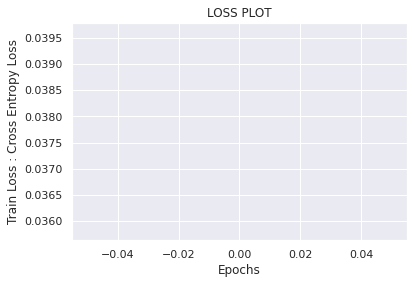

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


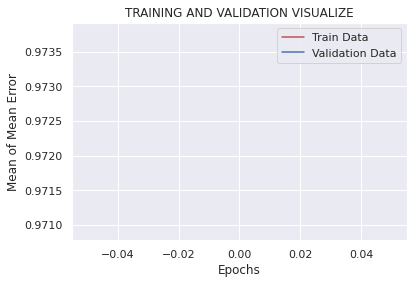

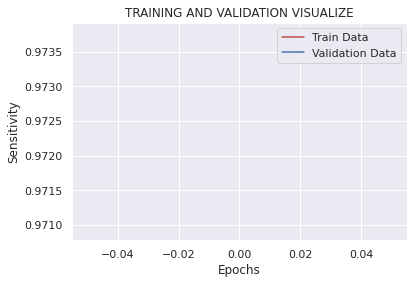

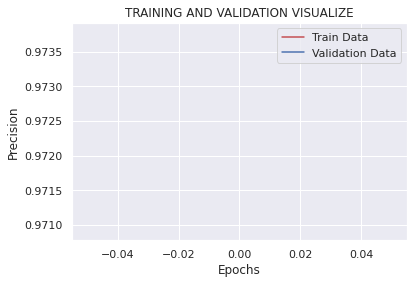

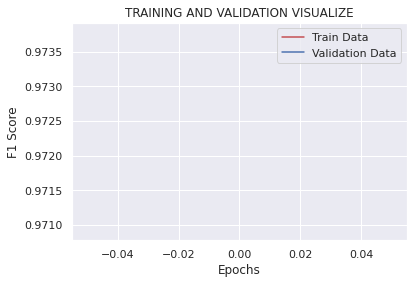

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




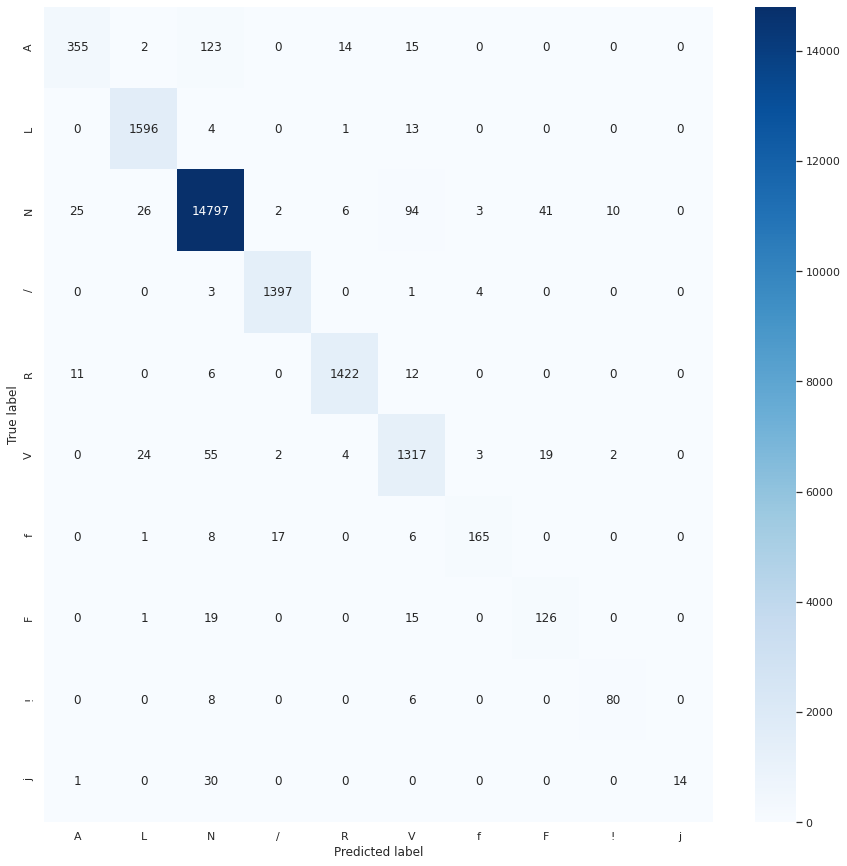



Metrics




,precision,recall,f1-score,Accuracy
A,0.905612,0.697446,0.788013,0.991281
L,0.967273,0.988848,0.977941,0.996713
N,0.982993,0.986204,0.984596,0.978864
/,0.985190,0.994306,0.989727,0.998676
R,0.982723,0.980014,0.981366,0.997535
V,0.890467,0.923562,0.906713,0.987629
f,0.942857,0.837563,0.887097,0.998083
F,0.677419,0.782609,0.726225,0.995663
!,0.869565,0.851064,0.860215,0.998813
j,1.000000,0.311111,0.474576,0.998585


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




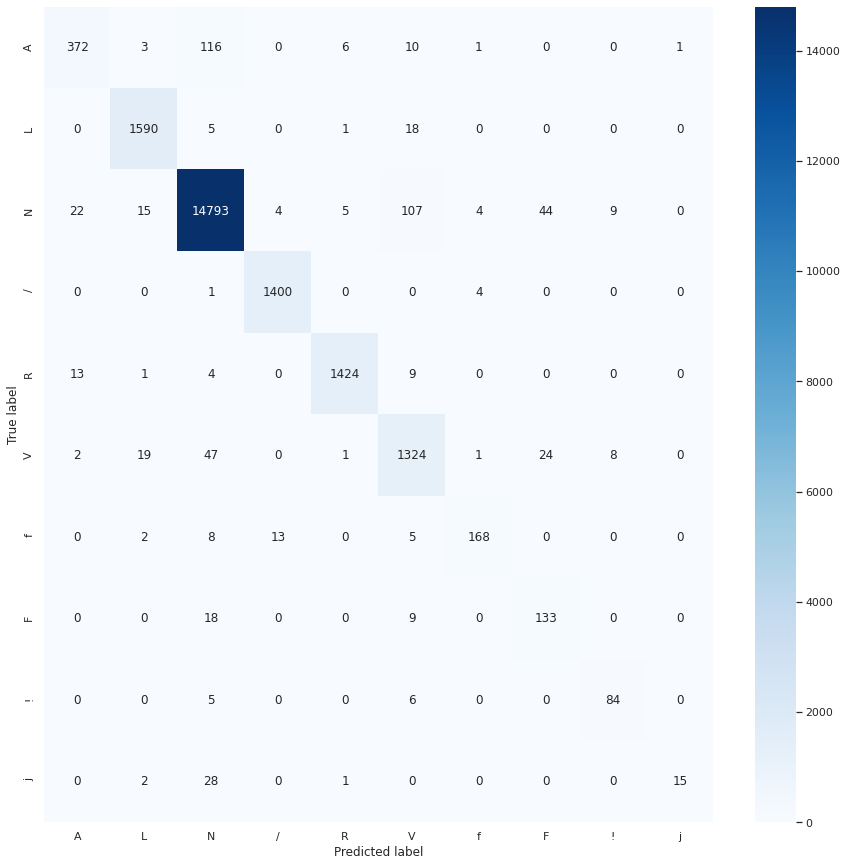



Metrics




,precision,recall,f1-score,Accuracy
A,0.909535,0.730845,0.810458,0.992057
L,0.974265,0.985130,0.979667,0.996987
N,0.984559,0.986003,0.985280,0.979822
/,0.988003,0.996441,0.992204,0.998996
R,0.990264,0.981392,0.985808,0.998128
V,0.889785,0.928471,0.908717,0.987857
f,0.943820,0.857143,0.898396,0.998265
F,0.661692,0.831250,0.736842,0.995663
!,0.831683,0.884211,0.857143,0.998722
j,0.937500,0.326087,0.483871,0.998539


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------


In [ ]:
test = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=1,config=config,verbose=False,visualize=True,download_model=False)

## Experiment - 1

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  10
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+-> Min Training Loss : 2.230280876159668
+-> Min Training Loss : 2.1015665531158447
+-> Min Training Loss : 2.0114033222198486
+-> Min Training Loss : 1.9223660230636597
+-> Min Training Loss : 1.907411813735962
+-> Min Training Loss : 1.728054404258728
+-> Min Training Loss : 1.6210979223251343
+-> Min Training Loss : 1.4293032884597778
+-> Min Training Loss : 1.2380653619766235
+-> Min Training Loss : 1.1224722862243652
+-> Min Training Loss : 1.1137276887893677
+-> Min Training Loss : 1.0456632375717163
+-> Min Training Loss : 0.9042955040931702
+-> Min Training Loss : 0.8448266386985779
+-> Min Training Loss : 0.8376938700675964
+-> Min Training Loss : 0.7947133779525757
+-> Min Training Loss : 0.7573285102844238
+-> Min Training Loss : 0.6290540099143982
+-> Min Training Loss : 0.4980447590351105
+-> Min Training Loss : 0.449251264333725
+-> Min Training Loss : 0.3851146399974823
+-> Min Training Loss : 0.3834296762943268
+-> Min Training Loss : 0.34897029399871826
+-> Min Traini

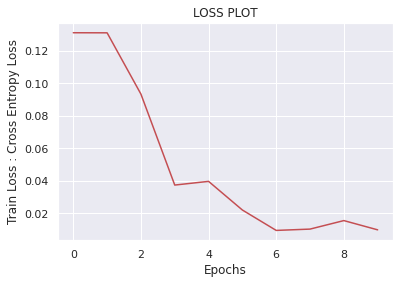

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


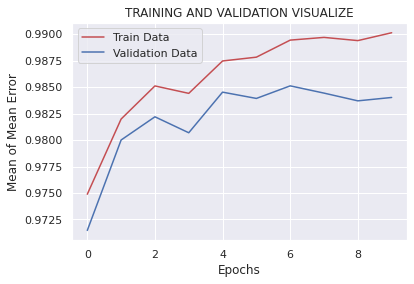

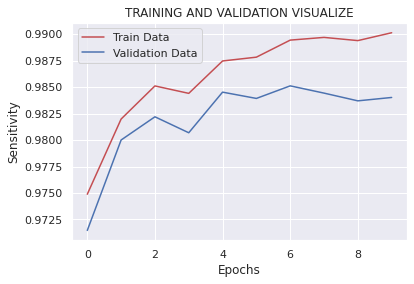

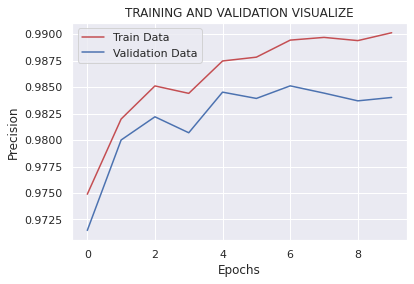

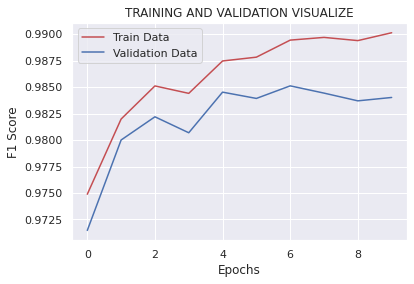

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




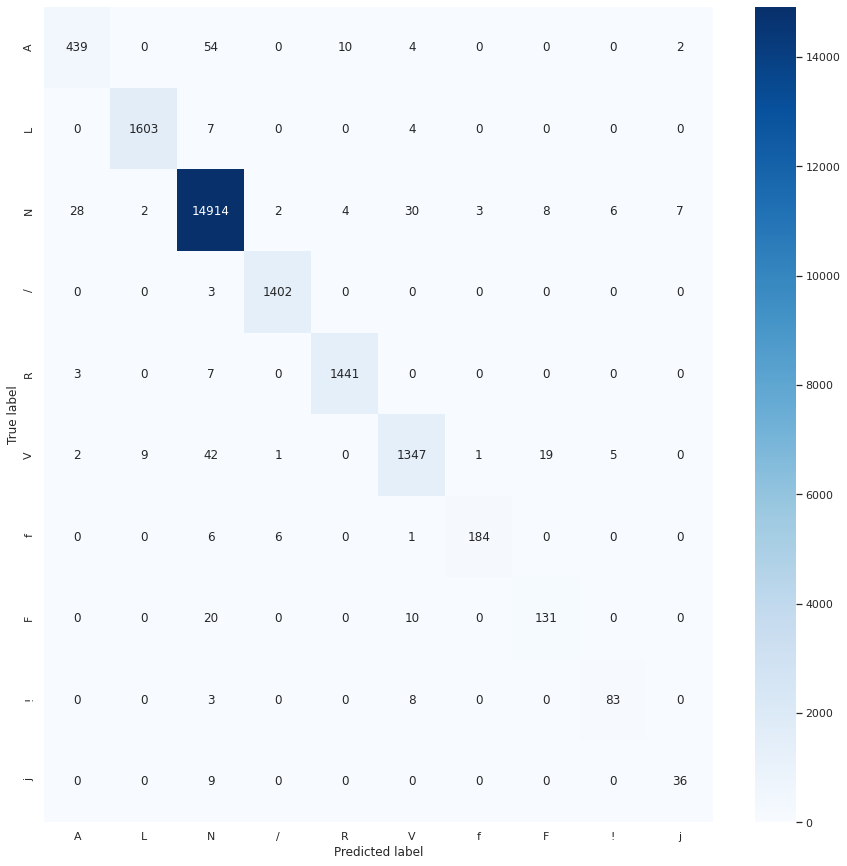



Metrics




,precision,recall,f1-score,Accuracy
A,0.930085,0.862475,0.895005,0.995298
L,0.993185,0.993185,0.993185,0.998996
N,0.989977,0.994002,0.991985,0.988998
/,0.993622,0.997865,0.995739,0.999452
R,0.990378,0.993108,0.991741,0.998904
V,0.959402,0.944600,0.951943,0.993792
f,0.978723,0.934010,0.955844,0.999224
F,0.829114,0.813665,0.821317,0.997398
!,0.882979,0.882979,0.882979,0.998996
j,0.800000,0.800000,0.800000,0.999178


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




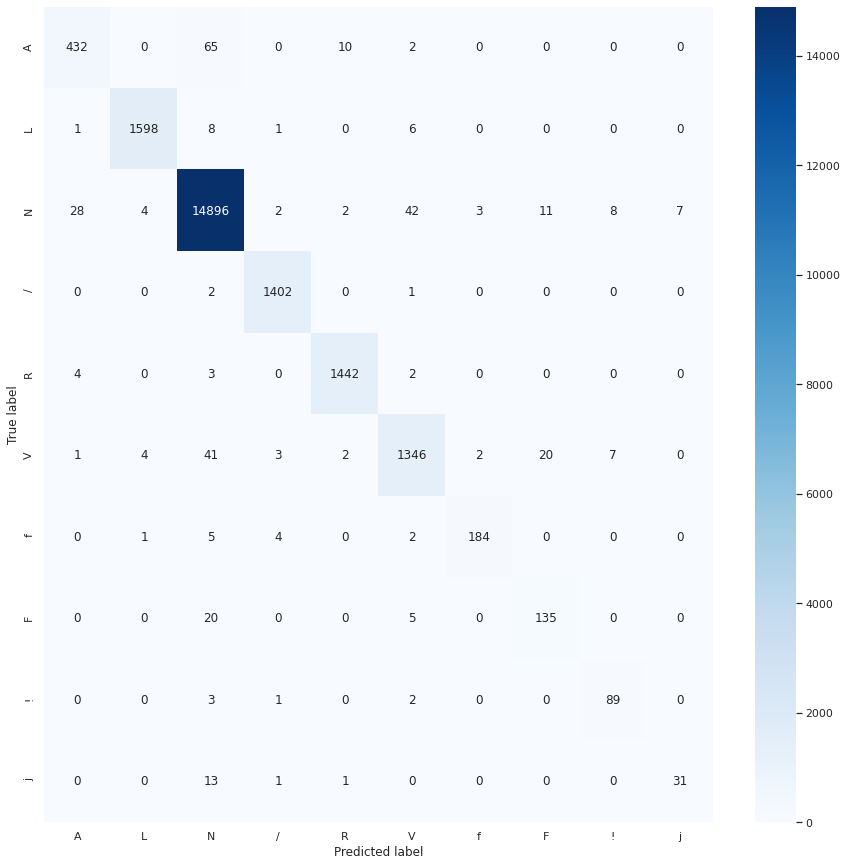



Metrics




,precision,recall,f1-score,Accuracy
A,0.927039,0.848723,0.886154,0.994933
L,0.994400,0.990087,0.992238,0.998859
N,0.989373,0.992868,0.991117,0.987811
/,0.991513,0.997865,0.994679,0.999315
R,0.989705,0.993797,0.991747,0.998904
V,0.955966,0.943899,0.949894,0.993517
f,0.973545,0.938776,0.955844,0.999224
F,0.813253,0.843750,0.828221,0.997444
!,0.855769,0.936842,0.894472,0.999041
j,0.815789,0.673913,0.738095,0.998996


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...


NameError: ignored

In [ ]:
best_val_model = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=10,config=config,verbose=False,visualize=True,download_model=True)

## Experiment-2

------------------------------------------------------------------------------------------
			 TRAINING EXPERIMENT
------------------------------------------------------------------------------------------
	 TRAINING CONFIGURATION
------------------------------------------------------------------------------------------
--> The HeartNet Model is being trained for Beat Classification
--> You are using a  gpu
--> The epochs specified for training :  10
------------------------------------------------------------------------------------------
	 TRAINING
------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+-> Min Training Loss : 2.6249444484710693
+-> Min Training Loss : 2.5601789951324463
+-> Min Training Loss : 2.346421003341675
+-> Min Training Loss : 2.174804210662842
+-> Min Training Loss : 1.988099455833435
+-> Min Training Loss : 1.9369418621063232
+-> Min Training Loss : 1.9199305772781372
+-> Min Training Loss : 1.6942185163497925
+-> Min Training Loss : 1.6759406328201294
+-> Min Training Loss : 1.6370965242385864
+-> Min Training Loss : 1.605505108833313
+-> Min Training Loss : 1.4543379545211792
+-> Min Training Loss : 1.4104951620101929
+-> Min Training Loss : 1.3368351459503174
+-> Min Training Loss : 1.173345685005188
+-> Min Training Loss : 1.0982513427734375
+-> Min Training Loss : 1.0944161415100098
+-> Min Training Loss : 1.0255866050720215
+-> Min Training Loss : 0.9145406484603882
+-> Min Training Loss : 0.8375877141952515
+-> Min Training Loss : 0.7792224287986755
+-> Min Training Loss : 0.7246515154838562
+-> Min Training Loss : 0.6565478444099426
+-> Min Training

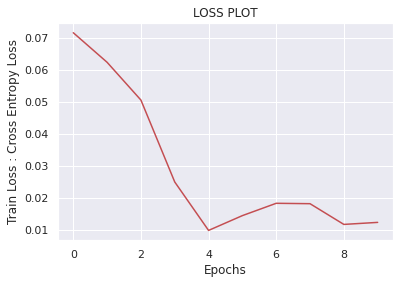

------------------------------------------------------------------------------------------
	 VISUALIZATION 
------------------------------------------------------------------------------------------


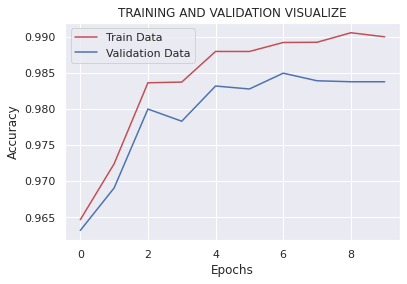

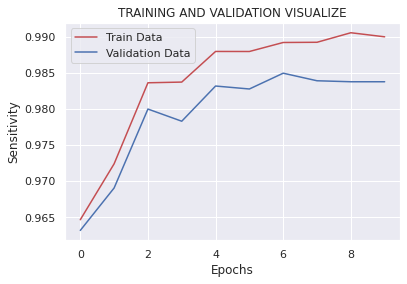

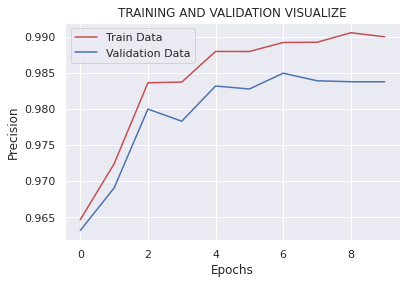

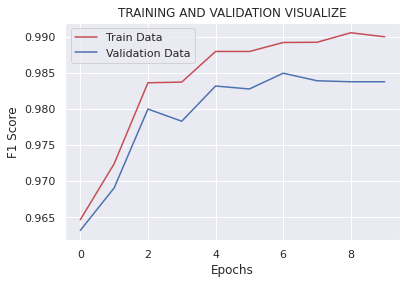

------------------------------------------------------------------------------------------
	 METRICS FOR BEST VALIDATION MODEL
------------------------------------------------------------------------------------------
VALIDATION SET
------------------------------------------------------------------------------------------
Confusion Matrix




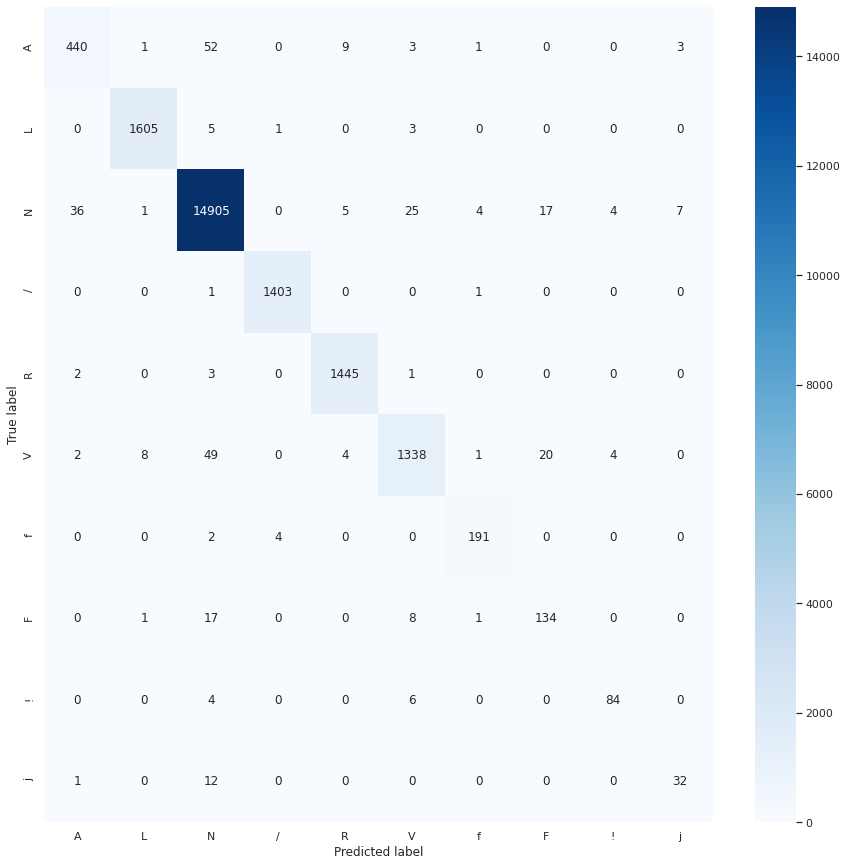



Metrics




,precision,recall,f1-score,Accuracy
A,0.914761,0.864440,0.888889,0.994979
L,0.993193,0.994424,0.993808,0.999087
N,0.990365,0.993402,0.991881,0.988861
/,0.996449,0.998577,0.997512,0.999680
R,0.987697,0.995865,0.991764,0.998904
V,0.966763,0.938289,0.952313,0.993883
f,0.959799,0.969543,0.964646,0.999361
F,0.783626,0.832298,0.807229,0.997078
!,0.913043,0.893617,0.903226,0.999178
j,0.761905,0.711111,0.735632,0.998950


------------------------------------------------------------------------------------------
TEST SET
------------------------------------------------------------------------------------------
Confusion Matrix




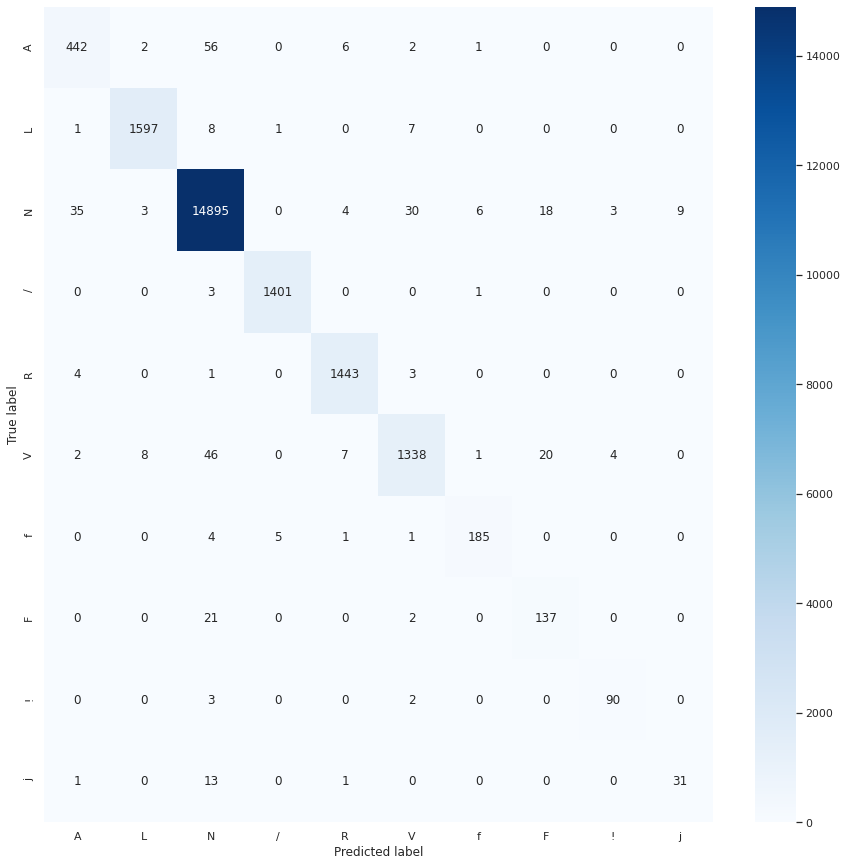



Metrics




,precision,recall,f1-score,Accuracy
A,0.911340,0.868369,0.889336,0.994978
L,0.991925,0.989467,0.990695,0.998630
N,0.989701,0.992801,0.991249,0.987994
/,0.995736,0.997153,0.996444,0.999543
R,0.987004,0.994487,0.990731,0.998767
V,0.966065,0.938289,0.951974,0.993837
f,0.953608,0.943878,0.948718,0.999087
F,0.782857,0.856250,0.817910,0.997215
!,0.927835,0.947368,0.937500,0.999452
j,0.775000,0.673913,0.720930,0.998904


------------------------------------------------------------------------------------------
	 EVALUATION COMPLETE
------------------------------------------------------------------------------------------
DOWNLOADING MODEL ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DOWNLOADING COMPLETE !!!


In [ ]:
best_val_model = ultimate_trainer(trainData=train_dict,valData=val_dict,testData=test_dict,epochs=10,config=config,verbose=False,visualize=True,download_model=True)